In [39]:
#Please define the destinations you are interested in. Make sure the format is appropriate, like in the example

#destinations = ["Athens", "Salonica", "Mykonos", "Santorini", "Crete","Preveza","Naxos"]
#destinations = ["Manhattan", "Brooklyn", "Times Square", "Central Park", "Empire State Building","Wall Street"]
destinations = ["Athens", "Rome", "Munich", "London", "Vienna","Paris","Barcelona"]

#Please select the Sample Size. It can be up to 1,000 hotels.

num_iterations=500

In [40]:
#Importing all necessary libraries / modules (in random order, but all of them are needed)

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import time, re
import numpy as np
import matplotlib.pyplot as plt

from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains

In [41]:
#Creating a method that scrapes info for hotels in a specific destination

def get_hotel_info(destination, num_iterations):
    # Webdriver options
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    # Set up the webdriver with the specified options
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)  
    driver.get("https://www.booking.com/") # Open booking.com

    try:# Click on the "accept cookies" button, if it exists
        accept_cookies_button = driver.find_element(By.XPATH,'//*[@id="onetrust-accept-btn-handler"]')
        accept_cookies_button.click()
    except NoSuchElementException:
        pass

    # Find the search box and enter the destination
    search_box = driver.find_element(By.NAME,'ss')
    search_box.send_keys(destination)
    search_box.send_keys(Keys.RETURN)

    # Wait for the result pages to load
    time.sleep(3)
    
    # Set the destination again for good measure
    new_search_box = driver.find_element(By.NAME,'ss')
    ActionChains(driver).move_to_element(new_search_box).click().perform()

    # SLOWLY clear the contents of the search box
    ActionChains(driver).click(new_search_box).key_down(Keys.CONTROL).send_keys("a").key_up(Keys.CONTROL).send_keys(Keys.DELETE).perform()
    
    new_search_box.send_keys(destination) # Enter the destination and submit the search
    time.sleep(3) # Wait for the page to update
    new_search_box.send_keys(Keys.RETURN)
    
    # More waiting to make sure we have at last the correct result pages
    time.sleep(5)

    # Create an empty list to store the hotel information and a cruder one for study purposes
    hotel_info = []
    hotel_info_new = []

    iteration = 0
    while iteration < num_iterations:
        # Find all hotel items on the page
        hotel_items = driver.find_elements(By.CLASS_NAME,'b978843432')

        # Loop through the hotel items and extract the desired information
        for item in hotel_items:
            item_list=item.text.split('\n')
            
            #Extract the hotel info
            try:
                l2 = [x for x in item_list if 'review' in x.lower() or 'reviews' in x.lower()][0]
                idx_l2 = item_list.index(l2)
                if idx_l2 > 1:
                    el2 = re.search(r'\d+', l2)
                    if el2 is not None:
                        el2 = int(el2.group(0))
                    else:
                        continue  # Skip hotels with no reviews
                    el3 = None
                    try:
                        el3 = float(item_list[idx_l2-2])
                    except ValueError:
                    # cannot convert to float, break the loop
                        return hotel_info_new
                    el4 = item_list[idx_l2-1]
                    # Create a new dictionary with the desired information
                    hotel_info_item = {
                        'Hotel_name': item_list[0],
                        'Reviews': int(el2),
                        'Rating': el3,
                        'Quality': el4,
                    }
                    
                    # Add the hotel information to the list
                    hotel_info.append(item_list)
                    hotel_info_new.append(hotel_info_item)
                else:
                    continue  # Skip hotels with no reviews

            except IndexError:
                continue  # Skip hotels with no reviews

            iteration += 1
            if iteration == num_iterations:
                break

        # Find the "Next page" button - Sadly only this weird xpath works...
        try:
            next_button = driver.find_element(By.XPATH,'//*[@id="search_results_table"]/div[2]/div/div/div[4]/div[2]/nav/div/div[3]/button')
        except NoSuchElementException:
            break  # Stop the loop if the "Next page" button is not found

        # Click on the "Next page" button
        next_button.click()

        # Wait for the page to load
        time.sleep(3)

    driver.quit()
    return hotel_info_new

In [42]:
#Creating a method that calculates the weighted average Rating for the hotels in a specific destination (makes sure only actual numbers are involved)

def get_weighted_average_rating(hotel_info):
    ratings = []
    reviews = []
    for hotel in hotel_info:
        if isinstance(hotel['Rating'], (int, float)) and isinstance(hotel['Reviews'], (int, float)) and hotel['Reviews'] > 0:
            ratings.append(hotel['Rating'])
            reviews.append(hotel['Reviews'])
    if len(ratings) == 0:
        return None
    else:
        weighted_average = np.average(ratings, weights=reviews)
        return weighted_average

In [43]:
#Creating a method that performs the procedure for a vector of destinations and a specific number (sample) of hotels

def get_average_ratings(destinations):
    average_ratings = []
    for destination in destinations:
        hotel_info = get_hotel_info(destination, num_iterations)
        if len(hotel_info) == 0:# This is a rare case. Running everything again will probably produce a valid average rating
            average_ratings.append(None)
            print(f"Destination {dest} doesn't have a valid average rating and an error will be produced - please try again")
        else:
            average_ratings.append(get_weighted_average_rating(hotel_info))
    return average_ratings

# Get the average ratings for the destinations
avg_ratings = get_average_ratings(destinations)

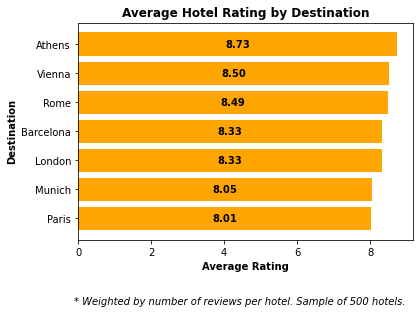

In [44]:
# Sort the destinations and avg_ratings lists in descending order of avg_ratings
destinations, avg_ratings = zip(*sorted(zip(destinations, avg_ratings), key=lambda x: x[1], reverse=True))

# Plot the horizontal bar chart
plt.barh(destinations, avg_ratings, color='orange')

# Add a title
plt.title('Average Hotel Rating by Destination', fontweight='bold')

# Add x and y axis labels, with bold font
plt.xlabel('Average Rating', fontweight='bold')
plt.ylabel('Destination', fontweight='bold')

# Add text labels inside the bars
for i, v in enumerate(avg_ratings):
    plt.text(v/2, i, "{:.2f}".format(v), ha='center', va='center', fontweight='bold')

# Add note at the bottom
plt.figtext(0.5, -0.1, f'* Weighted by number of reviews per hotel. Sample of {num_iterations} hotels.', ha='center', fontstyle='italic')

# Invert the y-axis to show the longest bars at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()
